In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import itertools

pitch = pd.read_csv("Coding/savant_pitch_level.csv")

In [4]:
count = pitch.groupby('pitch_type').size()
count

pitch_type
CH    238073
CS       303
CU    160681
EP      1165
FA      3245
FC    156820
FF    717343
FO       778
FS     38096
KC     42931
KN       278
PO       120
SC        75
SI    329169
SL    377443
ST     61387
SV      7422
dtype: int64

In [5]:
pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST']
handedness = ['R', 'L']

In [6]:
pitch['pitch_id'] = (
    pitch['game_pk'].astype(str) + '_' +
    pitch['pitcher'].astype(str) + '_' +
    pitch['batter'].astype(str) + '_' +
    pitch['pitch_number_appearance'].astype(str) 
)

duplicate_pitch_ids = pitch['pitch_id'].duplicated(keep=False)
duplicates = pitch[duplicate_pitch_ids]

In [7]:
duplicates

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,spin_axis,delta_home_win_exp,delta_run_exp,role_key,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced,pitch_id


In [8]:
def create_df(pitch_type, handedness, original_df):
    filtered_df = original_df.loc[(original_df['pitch_type'] == pitch_type) & (original_df['p_throws'] == handedness)]
    
    filtered_df = filtered_df[['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed', 
                            'pitch_id']].dropna(subset=['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed'])
    
    return filtered_df

In [9]:
def create_scaler(df):
    stats = df[['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed']]
    scaler = StandardScaler()

    stats_scaled = scaler.fit_transform(stats)
    
    temp_df = pd.DataFrame(stats_scaled, columns = stats.columns)

    df_reset = df.reset_index(drop = True)

    df_scaled = pd.concat([df_reset[['pitch_id']], temp_df], axis = 1)

    return df_scaled

In [10]:
def create_elbow_plot(X, handedness, max_clusters=10, save_fig=False, filename=None):
    numerical_X = X.select_dtypes(include = 'float64')
    
    distortions = []
    K = range(1, max_clusters + 1)

    for k in K:
        kmeans = KMeans(n_clusters = k, n_init = 10)
        kmeans.fit(numerical_X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

In [ ]:
for hand in handedness:
    for pitch_type in pitch_types:
            
        df = create_df(pitch_type, hand, pitch)
            
        if not df.empty:
            df_scaled = create_scaler(df)
            print(f"Elbow Plot for {pitch_type} {hand}")
            create_elbow_plot(df_scaled, hand)

In [12]:
r_clust = {'FF': 3, 'SL': 4, 'CU': 4, 'SI': 4, 'CH': 4,'FS': 3,'KC': 3,'FC': 3, 'ST': 3}
l_clust = {'FF': 3, 'SL': 4, 'CU': 4, 'SI': 3, 'CH': 4,'FS': 3,'KC': 3,'FC': 3,'ST': 4}

In [13]:
def add_cluster_labels(num_clusters, hand, original_df):
    dfs = {}
    
    for pitch_type in pitch_types:

        df_name = f'r_{pitch_type}'
        
        df = create_df(pitch_type, hand, original_df)

        scaled = create_scaler(df)

        kmeans = KMeans(n_clusters = num_clusters[pitch_type], n_init = 10, random_state = 42)
        labels = kmeans.fit_predict(scaled)

        df['cluster'] = labels
        
        dfs[df_name] = df
    
    return dfs

In [73]:
r_dfs = add_cluster_labels(r_clust, 'R', pitch)
l_dfs = add_cluster_labels(l_clust, 'L', pitch)

In [74]:
r_pitch_temp = [r_dfs[df][['pitch_id', 'cluster']].merge(pitch, on='pitch_id') for df in r_dfs.keys()]
r_pitch = pd.concat(r_pitch_temp, ignore_index=True)

r_pitch['pitch_cluster'] = r_pitch['pitch_type'].astype(str) + '_' + \
                r_pitch['cluster'].astype(str) 

In [16]:
l_pitch_temp = [l_dfs[df][['pitch_id', 'cluster']].merge(pitch, on='pitch_id') for df in l_dfs.keys()]
l_pitch = pd.concat(l_pitch_temp, ignore_index=True)

l_pitch['pitch_cluster'] = l_pitch['pitch_type'].astype(str) + '_' + \
                 l_pitch['cluster'].astype(str) 

In [75]:
r_pitch['ground_ball'] = np.where(r_pitch['bb_type'].notnull() & (r_pitch['bb_type'] == "ground_ball"), 1, 0)
r_pitch['popup'] = np.where(r_pitch['bb_type'].notnull() & (r_pitch['bb_type'] == "popup"), 1, 0)
r_pitch['sw_str'] = np.where(r_pitch['description'].notnull() & (r_pitch['description'] == "swinging_strike"), 1, 0)
r_pitch['weak_contact'] = np.where(r_pitch['launch_speed_angle'].notnull() & r_pitch['launch_speed_angle'].isin([1, 2, 3, 4]), 1, 0)

r_cluster_stats = r_pitch.groupby(['pitch_type', 'pitch_cluster']).agg({
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean',
    'woba_value': 'mean',
    'ground_ball': 'mean',
    'popup': 'mean',
    'sw_str': 'mean',
    'weak_contact': 'mean'
}).reset_index()

r_cluster_stats['ground_ball'] *= 100
r_cluster_stats['popup'] *= 100
r_cluster_stats['sw_str'] *= 100
r_cluster_stats['weak_contact'] *= 100
r_cluster_stats['pfx_x'] *= 12
r_cluster_stats['pfx_z'] *= 12

In [18]:
l_pitch['ground_ball'] = np.where(l_pitch['bb_type'].notnull() & (l_pitch['bb_type'] == "ground_ball"), 1, 0)
l_pitch['popup'] = np.where(l_pitch['bb_type'].notnull() & (l_pitch['bb_type'] == "popup"), 1, 0)
l_pitch['sw_str'] = np.where(l_pitch['description'].notnull() & (l_pitch['description'] == "swinging_strike"), 1, 0)
l_pitch['weak_contact'] = np.where(l_pitch['launch_speed_angle'].notnull() & l_pitch['launch_speed_angle'].isin([1, 2, 3, 4]), 1, 0)

l_cluster_stats = l_pitch.groupby(['pitch_type', 'pitch_cluster']).agg({
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean',
    'woba_value': 'mean',
    'ground_ball': 'mean',
    'popup': 'mean',
    'sw_str': 'mean',
    'weak_contact': 'mean'
}).reset_index()

l_cluster_stats['ground_ball'] *= 100
l_cluster_stats['popup'] *= 100
l_cluster_stats['sw_str'] *= 100
l_cluster_stats['weak_contact'] *= 100
l_cluster_stats['pfx_x'] *= 12
l_cluster_stats['pfx_z'] *= 12

In [76]:
r_pitch

,pitch_id,cluster,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced,pitch_cluster,ground_ball,popup,sw_str,weak_contact
0,634601_608379_543877_90,3,CH,2021-04-05,87.2,-1.65,6.47,"Wacha, Michael",543877,608379,...,1,0,90,24,3,CH_3,1,0,0,1
1,634601_608379_543877_88,3,CH,2021-04-05,86.2,-1.55,6.63,"Wacha, Michael",543877,608379,...,1,0,88,24,3,CH_3,0,0,0,0
2,634601_608379_543877_85,3,CH,2021-04-05,87.7,-1.68,6.53,"Wacha, Michael",543877,608379,...,1,0,85,24,3,CH_3,0,0,0,0
3,634562_594965_572816_82,3,CH,2021-04-05,86.1,-2.66,6.55,"Ponce de Leon, Daniel",572816,594965,...,1,0,82,19,3,CH_3,1,0,0,1
4,634588_570632_593934_81,3,CH,2021-04-05,89.7,-1.51,6.08,"Ureña, José",593934,570632,...,1,0,81,17,2,CH_3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525883,718023_676760_641525_3,0,ST,2023-05-26,79.7,-3.55,4.93,"Marinaccio, Ron",641525,676760,...,0,1,3,2,1,ST_0,0,0,0,0
1525884,718019_543521_664761_3,0,ST,2023-05-26,80.3,-2.41,5.42,"McHugh, Collin",664761,543521,...,0,1,3,1,1,ST_0,0,0,0,1
1525885,718018_687330_605141_2,0,ST,2023-05-26,75.2,-1.81,3.23,"Kelly, Kevin",605141,687330,...,0,1,2,1,1,ST_0,0,0,0,0
1525886,718018_676534_678246_2,0,ST,2023-05-26,89.4,-1.72,6.11,"Faucher, Calvin",678246,676534,...,0,1,2,1,1,ST_0,0,0,0,0


In [ ]:
r_pitch_clusters = list(r_pitch['pitch_cluster'].unique())

r_pairs = list(itertools.combinations(r_pitch_clusters, 2))


r_all_pitches = r_pitch.groupby('pitcher')['pitch_cluster'].agg(lambda x: sorted(set(x))).reset_index().rename(columns={'pitch_cluster': 'all_pitches'})


r_pitch = pd.merge(r_all_pitches, r_pitch, on = 'pitcher', how = 'left')


r_pair_stats = []


for pair in r_pairs:
    sorted_pair = sorted(pair)
    selected_rows = r_pitch[r_pitch['all_pitches'].apply(lambda x: all(item in x for item in sorted_pair))]
    
    if not selected_rows.empty:
        mean_woba_value = selected_rows['woba_value'].mean()
        mean_ground_ball = selected_rows['ground_ball'].mean()
        mean_popup = selected_rows['popup'].mean()
        mean_sw_str = selected_rows['sw_str'].mean()
        mean_weak_contact = selected_rows['weak_contact'].mean()
        
        r_pair_stats.append({'combination': pair, 
                           'mean_woba_value': mean_woba_value,
                           'mean_ground_ball': mean_ground_ball,
                           'mean_popup': mean_popup,
                           'mean_sw_str': mean_sw_str,
                           'mean_weak_contact': mean_weak_contact})



r_pair_stats_df = pd.DataFrame(r_pair_stats).sort_values(by = 'mean_woba_value', ascending = False)

In [79]:
r_pair_stats_df

,combination,mean_woba_value,mean_ground_ball,mean_popup,mean_sw_str,mean_weak_contact
461,"(SL_3, ST_1)",0.326868,0.074961,0.012487,0.103443,0.150281
113,"(CH_0, ST_1)",0.326847,0.075603,0.012413,0.102327,0.151544
19,"(CH_3, SI_3)",0.326651,0.079918,0.011437,0.101171,0.152998
3,"(CH_3, CU_0)",0.326291,0.075644,0.012511,0.102858,0.151578
48,"(CH_2, SI_3)",0.326257,0.079883,0.011470,0.101273,0.153011
...,...,...,...,...,...,...
397,"(KC_2, ST_2)",0.296122,0.062799,0.014556,0.111666,0.137763
408,"(KC_1, ST_2)",0.296122,0.062799,0.014556,0.111666,0.137763
372,"(FS_1, ST_2)",0.294617,0.067723,0.014302,0.112766,0.142386
343,"(FS_0, ST_2)",0.294617,0.067723,0.014302,0.112766,0.142386


In [21]:
l_pitch_clusters = list(l_pitch['pitch_cluster'].unique())

l_pairs = list(itertools.combinations(l_pitch_clusters, 2))


l_all_pitches = l_pitch.groupby('pitcher')['pitch_cluster'].agg(lambda x: sorted(set(x))).reset_index().rename(columns={'pitch_cluster': 'all_pitches'})


l_pitch = pd.merge(l_all_pitches, l_pitch, on = 'pitcher', how = 'left')


l_pair_stats = []


for pair in l_pairs:
    sorted_pair = sorted(pair)
    selected_rows = l_pitch[l_pitch['all_pitches'].apply(lambda x: all(item in x for item in sorted_pair))]
    
    if not selected_rows.empty:
        mean_woba_value = selected_rows['woba_value'].mean()
        mean_ground_ball = selected_rows['ground_ball'].mean()
        mean_popup = selected_rows['popup'].mean()
        mean_sw_str = selected_rows['sw_str'].mean()
        mean_weak_contact = selected_rows['weak_contact'].mean()
        
        l_pair_stats.append({'combination': pair, 
                           'mean_woba_value': mean_woba_value,
                           'mean_ground_ball': mean_ground_ball,
                           'mean_popup': mean_popup,
                           'mean_sw_str': mean_sw_str,
                           'mean_weak_contact': mean_weak_contact})



l_pair_stats_df = pd.DataFrame(l_pair_stats).sort_values(by = 'mean_woba_value', ascending = False)

l_pair_stats_df.sort_values(by = 'mean_woba_value', ascending = False)


,combination,mean_woba_value,mean_ground_ball,mean_popup,mean_sw_str,mean_weak_contact
348,"(FS_2, ST_0)",0.355643,0.077397,0.012523,0.095052,0.154999
349,"(FS_2, ST_1)",0.355643,0.077397,0.012523,0.095052,0.154999
338,"(FS_0, ST_0)",0.355643,0.077397,0.012523,0.095052,0.154999
339,"(FS_0, ST_1)",0.355643,0.077397,0.012523,0.095052,0.154999
144,"(CU_2, FS_1)",0.351192,0.070588,0.015462,0.104874,0.159664
...,...,...,...,...,...,...
359,"(KC_0, ST_3)",0.293734,0.075949,0.014557,0.108228,0.155063
372,"(KC_2, ST_1)",0.293734,0.075949,0.014557,0.108228,0.155063
165,"(CU_1, FS_2)",0.280633,0.085012,0.013079,0.130788,0.152351
298,"(FF_1, FS_2)",0.280633,0.085012,0.013079,0.130788,0.152351


In [80]:
overall_diff = {}

for i, cluster in r_cluster_stats.iterrows():
    cluster_key = cluster['pitch_cluster']
    
    if cluster_key not in overall_diff:
        overall_diff[cluster_key] = []
    

    for i, row in r_pair_stats_df.iterrows():
        pitch_pair_key = row['combination']
        
        if cluster_key in pitch_pair_key:

            diff_row = {
                'subtype': pitch_pair_key[0], 
                'other_pitch': pitch_pair_key[1],
                'woba_diff': cluster['woba_value'] - row['mean_woba_value'],
                'gb_diff': cluster['ground_ball'] - row['mean_ground_ball'],
                'popup_diff': cluster['popup'] - row['mean_popup'],
                'sw_str_diff': cluster['sw_str'] - row['mean_sw_str'],
                'weak_contact_diff': cluster['weak_contact'] - row['mean_weak_contact']
            }

            overall_diff[cluster_key].append(diff_row)

diff_rows = []
for cluster_key, diffs in overall_diff.items():
    for diff in diffs:
        diff_row = {'cluster': cluster_key}
        diff_row.update(diff)
        diff_rows.append(diff_row)


diff_df = pd.DataFrame(diff_rows)

In [54]:
def plot_cluster_means(df, label, marker, linestyle, color, x_axis, y_axis):
    x = df[x_axis]
    y = df[y_axis]
    
    if len(x) > 0:
        x = np.append(x, x.iloc[0])
        y = np.append(y, y.iloc[0])
    
    plt.scatter(x, y, marker = marker, color = color, label = label)
    
    plt.plot(x, y, linestyle = linestyle, color = color)

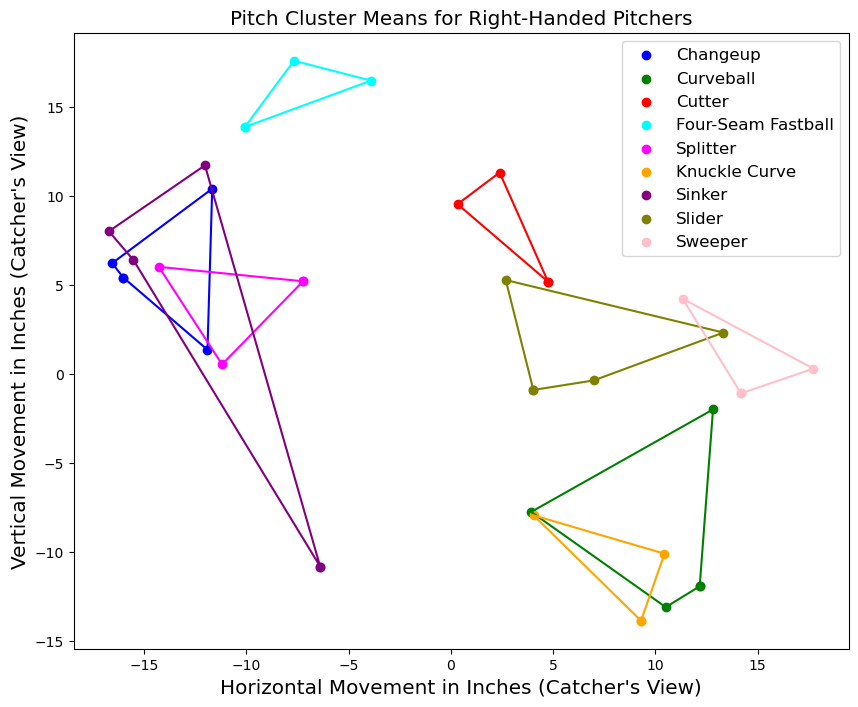

In [600]:
pitch_type_to_name = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FC': 'Cutter',
    'FF': 'Four-Seam Fastball',
    'FS': 'Splitter',
    'KC': 'Knuckle Curve',
    'SI': 'Sinker',
    'SL': 'Slider',
    'ST': 'Sweeper'
}

r_cluster_stats_plot = r_cluster_stats.replace({'pitch_type': pitch_type_to_name})

# Define custom colors and pitch type order
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple', 'olive', 'pink']
pitch_types = r_cluster_stats_plot['pitch_type'].unique()
color_map = dict(zip(pitch_types, colors))
manual_cluster_order_SI = ['SI_3', 'SI_1', 'SI_0', 'SI_2']
manual_cluster_order_SL = ['SL_0', 'SL_3', 'SL_1', 'SL_2']


plt.figure(figsize=(10, 8))


for pitch_type in pitch_types:
    pt_mean_stats = r_cluster_stats_plot[r_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey')  
    

    if pitch_type == 'Sinker':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_SI,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    elif pitch_type == 'Slider':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_SL,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
    

    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color = color, x_axis = "pfx_x", y_axis = "pfx_z")
    

plt.legend(fontsize = 'large')
plt.xlabel("Horizontal Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.ylabel("Vertical Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Right-Handed Pitchers', fontsize = 'x-large')


plt.savefig('rhp_cluster_plot.png')


plt.show()

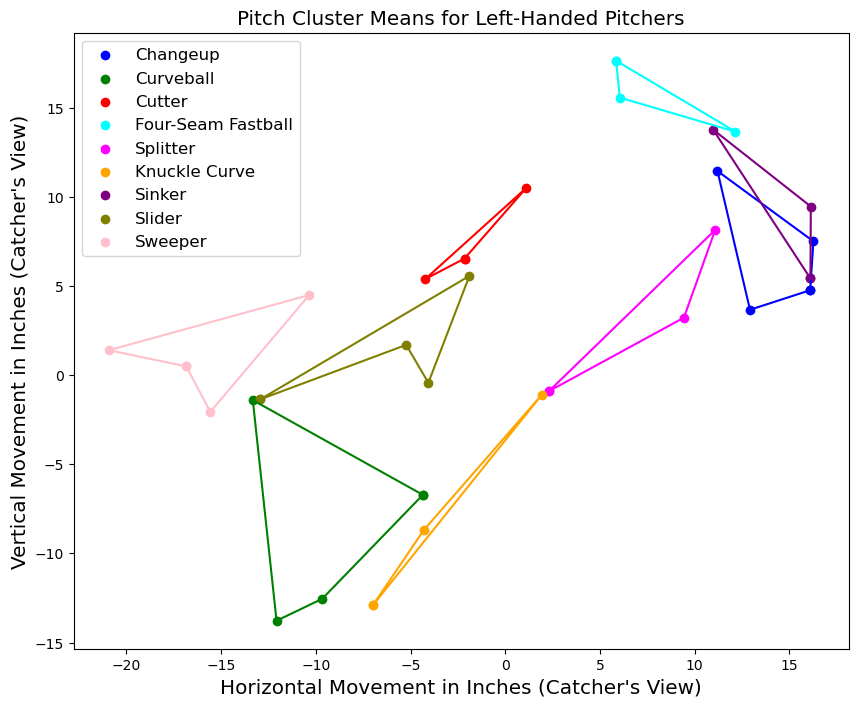

In [601]:
pitch_type_to_name = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FC': 'Cutter',
    'FF': 'Four-Seam Fastball',
    'FS': 'Splitter',
    'KC': 'Knuckle Curve',
    'SI': 'Sinker',
    'SL': 'Slider',
    'ST': 'Sweeper'
}


l_cluster_stats_plot = l_cluster_stats.replace({'pitch_type': pitch_type_to_name})

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple', 'olive', 'pink']
color_map = dict(zip(pitch_types, colors))

manual_cluster_order = ['SI_3', 'SI_1', 'SI_0', 'SI_2']
manual_cluster_order_cu = ['CU_3', 'CU_2', 'CU_0', 'CU_1']


pitch_types = l_cluster_stats_plot['pitch_type'].unique()


color_map = dict(zip(pitch_types, colors))

plt.figure(figsize = (10, 8))  


for pitch_type in pitch_types:
    pt_mean_stats = l_cluster_stats_plot[l_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey') 

    if pitch_type == 'Sinker':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    elif pitch_type == 'Curveball':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_cu,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
    

    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color = color, x_axis = "pfx_x", y_axis = "pfx_z")


plt.legend(fontsize = 'large')
plt.xlabel("Horizontal Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.ylabel("Vertical Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Left-Handed Pitchers', fontsize = 'x-large')
plt.savefig('lhp_cluster_plot.png')
plt.show()



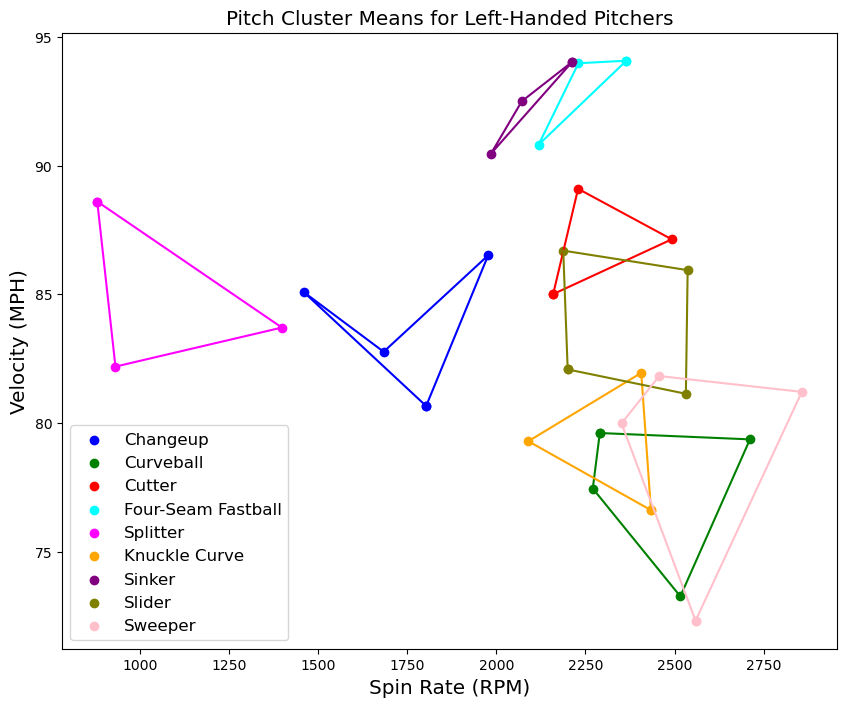

In [602]:
plt.figure(figsize=(10, 8))

manual_cluster_order_st = ['ST_3', 'ST_0', 'ST_2', 'ST_1']
manual_cluster_order_cu = ['CU_3', 'CU_2', 'CU_0', 'CU_1']
manual_cluster_order_sl = ['SL_2', 'SL_0', 'SL_3', 'SL_1']


for pitch_type in pitch_types:
    pt_mean_stats = l_cluster_stats_plot[l_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey')  

    if pitch_type == 'Slider':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_sl,
            ordered = True)
        pt_mean_stats.sort_values(by='pitch_cluster', inplace = True)
        
    elif pitch_type == 'Curveball':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_cu,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    elif pitch_type == 'Sweeper':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_st,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color = color, x_axis = "release_spin_rate", y_axis = "release_speed")

plt.legend(fontsize = 'large')
plt.xlabel("Spin Rate (RPM)", fontsize = 'x-large')
plt.ylabel("Velocity (MPH)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Left-Handed Pitchers', fontsize = 'x-large')


plt.savefig('lhp_sr_velo_plot.png')
plt.show()


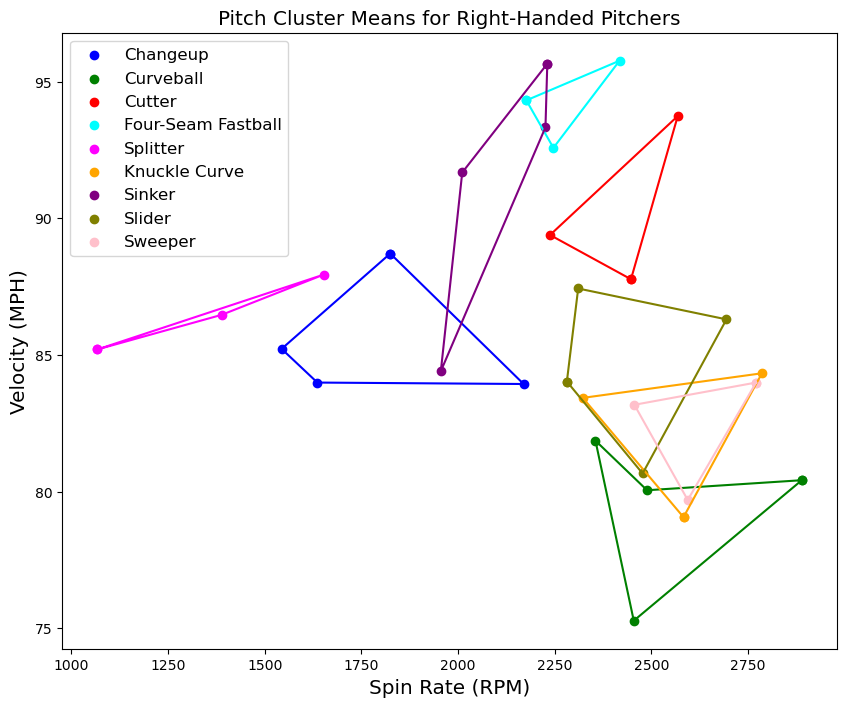

In [603]:
plt.figure(figsize=(10, 8))


manual_cluster_order_si = ['SI_0', 'SI_2', 'SI_3', 'SI_1']


for pitch_type in pitch_types:
    pt_mean_stats = r_cluster_stats_plot[r_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey')  

    if pitch_type == 'Sinker':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_si,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color=color, x_axis = "release_spin_rate", y_axis = "release_speed")

plt.legend(fontsize = 'large')
plt.xlabel("Spin Rate (RPM)", fontsize = 'x-large')
plt.ylabel("Velocity (MPH)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Right-Handed Pitchers', fontsize = 'x-large')


plt.savefig('rhp_sr_velo_plot.png')
plt.show()
